# UNet for SuperResolution (Pytorch)
For the course on Selected Topics on Artificial Intelligence <br>
CIMAT <br>
 <br>
 Structure:<br>
 1. Prepare training images based on STL-10 dataset
 2. Create & Train model
 3. Load trained weight



#### Importing libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
#import torchvision.transforms as transforms
from torch.autograd import Variable
#para dataset stl10
import torchvision.datasets as ds


## preprocesamiento de imagenes de entrenamiento

In [3]:
stl10ds = ds.STL10('./data', split='unlabeled', download=True)
imgs = stl10ds.data[:15000] #picks a slice
imgs = torch.from_numpy(imgs).type(torch.LongTensor)/255.
imgs_y = imgs
imgs_x = nn.functional.interpolate(imgs,size=[48,48])
train = torch.utils.data.TensorDataset(imgs_x,imgs_y)

Files already downloaded and verified


Text(0.5, 1.0, 'Original size 96x96')

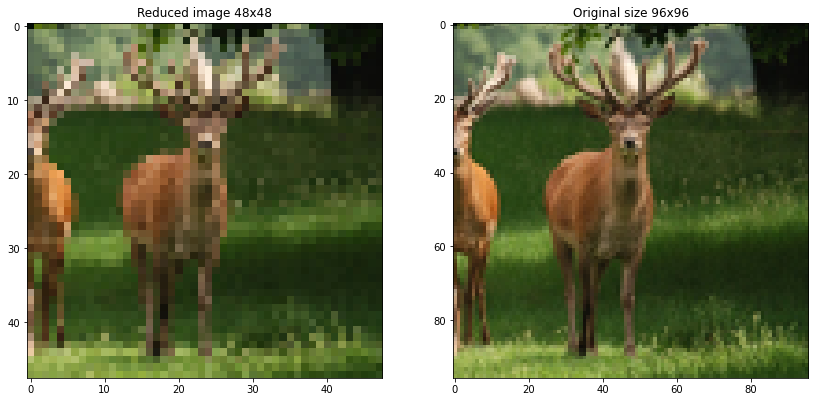

In [5]:
#images with reduced dimensions
idx = 10
tmpx=imgs_x.permute(0,2,3,1)
tmpy=imgs_y.permute(0,2,3,1)
plt.figure(figsize=(14,7))
plt.subplot(1,2,1)
plt.imshow(tmpx[idx])
plt.title('Reduced image 48x48')
plt.subplot(1,2,2)
plt.imshow(tmpy[idx])
plt.title('Original size 96x96')

In [6]:
batch_size = 70
iters = 30000
num_epochs=int(iters/(len(imgs_x)/batch_size))

In [7]:
train_loader= torch.utils.data.DataLoader(train,batch_size=batch_size,shuffle=True) 
#test_loader = torch.utils.data.DataLoader(test,batch_size=batch_size,shuffle=False)

## Unet

In [8]:
from unetSR import *

In [10]:
model = UNet(in_ch=3,out_ch=3)
#PARA USAR GPU
if torch.cuda.is_available():
    model.cuda()

In [11]:
error = nn.L1Loss()

In [12]:
# #error que uso el profe en su ejemplo
# dx = torch.Tensor([[1,0,-1],
#                  [2,0,-1],
#                  [1,0,-1]]).view((1,1,3,3))
# dy = torch.Tensor([[1,2,1],
#                  [0,0,0],
#                  [-1,-2,-1]]).view((1,1,3,3))

# Dx= torch.cat((dx,dx,dx)).cuda()
# Dy= torch.cat((dy,dy,dy)).cuda()

# def newloss(alpha=[1.0,1.0]):
#     def unet_super_loss(output,target):
#         residual = output-target
#         L1=torch.norm(residual,p=1)
#         L1grad = torch.abs(nn.functional.conv2d(input=residual,weight=Dx,groups=3)) +\
#         torch.abs(nn.functional.conv2d(input=residual,weight=Dy,groups=3))
#         return (alpha[0]*L1+alpha[1]*torch.sum(L1grad))
#     return unet_super_loss
                        
#         #44.19
# error2 = newloss(alpha=[1.0,0.3])

In [13]:
# error3 = nn.MSELoss()

In [14]:
optimizer = torch.optim.Adam(model.parameters(),lr=0.002,betas=(0.9,0.999),weight_decay=0.00001)

In [16]:
#from torchsummary import summary
#summary(model,(3,48,48))
#model.parameters()

In [17]:
import time 
tic = time.time()
count = 0
loss_list = []
iteration_list = []
accuracy_list = []
for epoch in range(num_epochs):
    for i,(imgs_x,imgs_y) in enumerate (train_loader):
        
        train = Variable(imgs_x.view(-1,3,48,48)).cuda() 
        test = Variable(imgs_y.view(-1,3,96,96)).cuda() 

        optimizer.zero_grad() #borra el gradiente
        outputs = model(train) #propagacion
        loss = error(outputs,test) #calcula el error
        loss.backward()    #retropropaga error
        optimizer.step()   #actualiza los parámetros
        count +=1
        
        if count%50 ==0:
            iteration_list.append(count)
            loss_list.append(loss.item())
            print('iter:{} loss:{}'.format(count,loss.data))
print('elapsed = ',time.time()-tic)

iter:50 loss:0.08227353543043137
iter:100 loss:0.06533551216125488
iter:150 loss:0.04859485849738121
iter:200 loss:0.048493191599845886
iter:250 loss:0.042274653911590576
iter:300 loss:0.04443508759140968
iter:350 loss:0.04106549546122551
iter:400 loss:0.0373869389295578
iter:450 loss:0.038621142506599426
iter:500 loss:0.03750397264957428
iter:550 loss:0.03969764709472656
iter:600 loss:0.03780786320567131
iter:650 loss:0.03548501804471016
iter:700 loss:0.03660082072019577
iter:750 loss:0.03568483516573906
iter:800 loss:0.03699597343802452
iter:850 loss:0.036017678678035736
iter:900 loss:0.03859322518110275
iter:950 loss:0.03935471549630165
iter:1000 loss:0.037134524434804916
iter:1050 loss:0.035763368010520935
iter:1100 loss:0.03369483724236488
iter:1150 loss:0.035738926380872726
iter:1200 loss:0.0346369706094265
iter:1250 loss:0.03253796324133873
iter:1300 loss:0.03635218366980553
iter:1350 loss:0.03435385599732399
iter:1400 loss:0.03479909151792526


KeyboardInterrupt: 

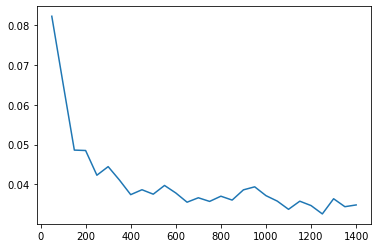

In [18]:
plt.plot(iteration_list,loss_list)

In [20]:
torch.save(model.state_dict(),'unet_final_2.pt')

### Predicción

In [32]:
#carga modelo:
model2 = UNet(3,3)
model2.load_state_dict(torch.load('unet_final_1.pt'))
model2.eval()
model2.cuda()

UNet(
  (in_layer): inconv(
    (up): Upsample(scale_factor=2.0, mode=bilinear)
    (conv): doubleconv2d(
      (doubleconv): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
        (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU(inplace=True)
      )
    )
  )
  (down1): Down(
    (down): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): doubleconv2d(
        (doubleconv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): ReLU(inplace=True)
          (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (3): ReLU(inplace=True)
        )
      )
    )
  )
  (down2): Down(
    (down): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): doubleconv2d(
        (doubleconv): Se

In [33]:
from matplotlib import image

In [34]:
img=image.imread('data/koko.jpg')

In [35]:
img.shape

(274, 267, 3)

In [36]:

imgTest = torch.from_numpy(np.copy(img)).type(torch.LongTensor)
imgTest = imgTest.permute(2,0,1)
channels,wTest,hTest = imgTest.shape
imgTest = (imgTest/255.).view(-1,3,wTest,hTest)



In [37]:
imgTest_x =  nn.functional.interpolate(imgTest,size=[wTest//2,hTest//2])

Text(0.5, 1.0, 'original')

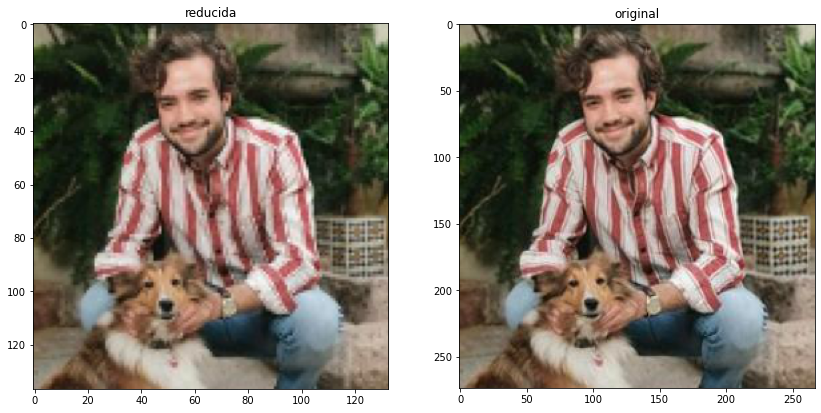

In [38]:
tmpx=imgTest_x.permute(0,2,3,1)
tmpy=imgTest.permute(0,2,3,1)
plt.figure(figsize=(14,7))
plt.subplot(1,2,1)
plt.imshow(tmpx[0])
plt.title('reducida')
plt.subplot(1,2,2)
plt.imshow(tmpy[0])
plt.title('original')

In [39]:
x_totrain = Variable(imgTest_x).cuda()
yhat2 = model2(x_totrain)

In [40]:
yhat2=yhat2.cpu().detach()

In [41]:
yhat2.shape

torch.Size([1, 3, 274, 266])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'pred')

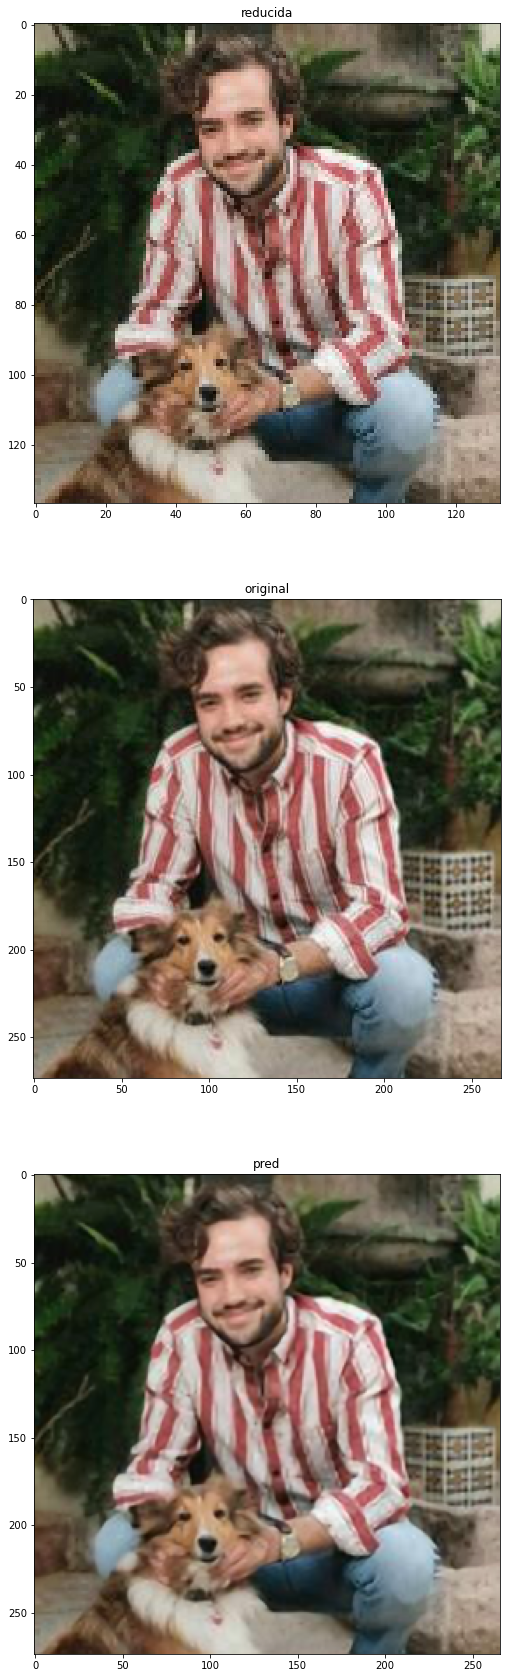

In [42]:
tmphat=yhat2.permute(0,2,3,1)

plt.figure(figsize=(10,30))
plt.subplot(3,1,1)
plt.imshow(tmpx[0])
plt.title('reducida')
plt.subplot(3,1,2)
plt.imshow(tmpy[0])
plt.title('original')
plt.subplot(3,1,3)
plt.imshow(tmphat[0])
plt.title('pred')